# Co-training

**Autori:** Peter Macinec, Lukas Janik, Vajk Pomichal, Frantisek Sefcik

## Zakladne nastavenia a import kniznic

In [1]:
import pandas as pd
import numpy as np


# plots
import matplotlib.pyplot as plt
import seaborn as sns

import json

import re

import nltk
from nltk.stem.porter import PorterStemmer
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection as ms

from sklearn.metrics import confusion_matrix

import statistics

from functools import reduce

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

### Nacitanie datasetu

Nase data su dostupne v dvoch suboroch, *train.tsv* a *test.tsv*. Nacitame ich oba a vykoname na nich zakladnu analyzu. Zdroj: https://www.kaggle.com/c/stumbleupon

In [2]:
# trenovacie data
df = pd.read_csv('data/train.tsv', sep='\t')

In [3]:
# testovacie data
df_t = pd.read_csv('data/test.tsv', sep='\t')

## Textove atributy

Najskor predspracujeme text. Ziskame ho z atributu boilerplate:

In [4]:
df['body_content'] = df['boilerplate'].apply(lambda x: json.loads(x)['body'])

Teraz odstranime vsetky znaky, ktore nie su znaky slov. Pouzijeme na to regularne vyrazy:

In [5]:
df['body_content'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

In [6]:
df['body_content'] = df['body_content'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))

Este ako male upravy, aby nas slovnik obsahoval kazde slovo len raz, dame ich vsetky na lowercase a rozdelime texty na slova, aby sme ich nasledne mohli spracovat:

In [7]:
df['body_content'] = df['body_content'].apply(lambda x: str(x).lower().split())

Teraz potrebujeme este odstranit slova, ktore nedavaju vyznam. O jednom raze prevedieme slova na ich korenovy zaklad pouzitim stemmingu:

In [8]:
porter_stemmer = PorterStemmer()
stopwords = set(stopwords.words('english'))

In [9]:
df['body_content'] = df['body_content'].apply(lambda x: [porter_stemmer.stem(word) for word in x if word not in stopwords])

Teraz uz mame vsetky slova pripravene, uz ich len naspat spojime do jednej suvislej vety, aby s nimi vedeli lahsie pracovat algoritmy spracovania textu:

In [10]:
df['body_content_final'] = df['body_content'].apply(lambda x: ' '.join(x))

### TF-IDF

In [11]:
tv = TfidfVectorizer(max_features = 1000)
tf_idf = tv.fit_transform(df['body_content_final']).toarray()

### Atribut URL

In [12]:
df['url_new'] = df['url'].apply(lambda x: re.sub('[^a-zA-Z]', ' ', str(x)))
df['url_new'] = df['url_new'].apply(lambda x: str(x).lower().split())

In [13]:
df['url_new'] = df['url_new'].apply(lambda x: [porter_stemmer.stem(word) for word in x if word not in stopwords])

In [14]:
df['url_final'] = df['url_new'].apply(lambda x: ' '.join(x))

In [15]:
tv_url = TfidfVectorizer(max_features = 1000)
tf_idf_url = tv_url.fit_transform(df['url_final']).toarray()

## Numericke atributy

In [16]:
num_feature_set = ['avglinksize', 'commonlinkratio_1', 'commonlinkratio_2', 'commonlinkratio_3', 'commonlinkratio_4',
                   'hasDomainLink','lengthyLinkDomain','linkwordscore','numberOfLinks',
                   'numwords_in_url', 'parametrizedLinkRatio']

## Benchmark model

Natrenujeme benchmarkovy model, ktory bude natrenovany na vsetkych atributoch. Jeho vysledky sa nasledne budeme snazit dosiahnut s minimom oznacenych dat s co-trainingom.

In [17]:
y = df.label

In [18]:
df1 = df.loc[:, num_feature_set]

In [19]:
df2 = pd.DataFrame(tf_idf_url)

In [20]:
X_temp = pd.concat([df2, pd.DataFrame(tf_idf)], axis=1, join_axes=[df2.index])
X_temp.columns = list(range(0,2000))

In [21]:
X = pd.concat([df1, X_temp], axis=1, join_axes=[df1.index])

In [22]:
X.head()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,hasDomainLink,lengthyLinkDomain,linkwordscore,numberOfLinks,numwords_in_url,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,2.055556,0.676471,0.205882,0.047059,0.023529,0,1,24,170,8,...,0.0,0.00000,0.157927,0.0,0.000000,0.028198,0.0,0.0,0.064583,0.0
1,3.677966,0.508021,0.288770,0.213904,0.144385,0,1,40,187,9,...,0.0,0.00000,0.031715,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,2.382883,0.562016,0.321705,0.120155,0.042636,0,1,55,258,11,...,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,1.543103,0.400000,0.100000,0.016667,0.000000,0,0,24,120,5,...,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,2.676471,0.500000,0.222222,0.123457,0.043210,0,1,14,162,10,...,0.0,0.02762,0.107720,0.0,0.129191,0.128223,0.0,0.0,0.088102,0.0


In [23]:
col_names1 = list(range(0,1000))
col_names1 = num_feature_set + col_names1
col_names2 = list(range(1000,2000))
# col_names2 = [str(i) for i in col_names2]

In [24]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
benchmark_clf = RandomForestClassifier(n_estimators=500, max_depth=20,
                              random_state=10)

In [26]:
benchmark_clf.fit(X_train, y_train)
y_pred = benchmark_clf.predict(X_test)

In [27]:
confusion_matrix(y_test, y_pred)

array([[656,  74],
       [221, 528]])

In [28]:
accuracy_score(y_test, y_pred)

0.8005409060175794

## Co-training zhodnotenie

In [29]:
class CombinedClassifier:
    
    def __init__(self,clf1, clf2, cols1, cols2):
        self.clf1 = clf1
        self.clf2 = clf2
        self.cols1 = cols1
        self.cols2 = cols2
        
    def predict(self, df):
        result = []
        for ind, row in df.iterrows():
            
            prob0 = self.clf1.predict_proba([df.loc[ind,self.cols1]])[0][0] * self.clf2.predict_proba([df.loc[ind,self.cols2]])[0][0]  
            prob1 = self.clf1.predict_proba([df.loc[ind,self.cols1]])[0][1] * self.clf2.predict_proba([df.loc[ind,self.cols2]])[0][1]
            res = 0 if prob0 > prob1 else 1
            result.append(res)
        return result

### Co-training s iteraciami

In [30]:
def co_training(L, U, col_names1, col_names2, clf1, clf2,u=75, k=30,p=1,n=3, label='label', X_test=None, y_test=None, random_state=None):
    '''
    L - labeled data
    U - unlabeled data
    col_names1 - columns for clf1
    col_names2 - columns for clf2
    clf1 - classificator1
    clf2 - classificator2
    u - number of unlabeled data for training
    k - number of iteration
    p - number of positive examles to add label per iteration
    n - number of negative examles to add label per iteration
    label - name of column in L whit label
    '''
    
#     U0 = U.sample(u, random_state= random_state)
#     U.drop(U0.index, inplace=True)
    k0 = k
    pred_1 = []
    pred_2 = []
    while k > 0:
        #print("iteration: ", k0 - k)
        # step 1: Use L to train a classifier h1 that considers only the x1 portion of x
        clf1 = clf1.fit(L[col_names1],  L[label])
        
        # step 2: Use L, to train a classifier h2 that considers only the x2 portion of x
        clf2 = clf2.fit(L[col_names2], L[label])
        
        # step 3: Allow hl to label p positive and n negative examples from U
        predicted_prob1 = clf1.predict_proba(U[col_names1])
        top_positive1 = predicted_prob1[:,1].argsort()[-p:]
        top_negative1 = predicted_prob1[:,0].argsort()[-n:]
        
        # step 4: Allow hl to label p positive and n negative examples from U
        predicted_prob2 = clf2.predict_proba(U[col_names2])
        top_positive2 = predicted_prob2[:,1].argsort()[-p:]
        top_negative2 = predicted_prob2[:,0].argsort()[-n:]    
        
        # step 5: Add these self-labeled examples to L
        positive_ind = U.iloc[np.unique(np.concatenate((top_positive1,top_positive2))),:].index
        negative_ind = U.iloc[np.unique(np.concatenate((top_negative1,top_negative2))),:].index
        self_labeled = U.loc[np.unique(np.concatenate((positive_ind,negative_ind))),:]
        U.drop(self_labeled.index, inplace=True)
        self_labeled.loc[positive_ind, label] = 1
        self_labeled.loc[negative_ind, label] = 0
        L = pd.concat([L, self_labeled])
    
        if (X_test is not None and y_test is not None):
            pred = clf1.predict(X_test[col_names1])
            pred_1.append(accuracy_score(y_test,pred))
            
            pred = clf2.predict(X_test[col_names2])
            pred_2.append(accuracy_score(y_test,pred))

        k -= 1
    
    return [clf1, clf2, pred_1, pred_2]

In [31]:
col_names1 = list(range(0,1000))
col_names1 = num_feature_set + col_names1
col_names2 = list(range(1000,2000))

In [34]:
scores = [[0 for _ in range(3)] for _ in range(30)]

for x in range(30):
    df_x0 = X_train[y_train == 0].sample(10)
    df_x1 = X_train[y_train == 1].sample(10)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression(n_jobs=-1)
    clf2 = LogisticRegression(n_jobs=-1)

    new_1, new_2, scores[x][0], scores[x][1] = co_training(L=train,U=x_train, 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, k=30, 
                                                           n=2, p=2, X_test=X_test, y_test=y_test)
    
    
    print("iteration:", x)
#     pred = new_1.predict(X_test[col_names1])
#     scores[0].append(accuracy_score(y_test, pred))

#     pred = new_2.predict(X_test[col_names2])
#     scores[1].append(accuracy_score(y_test, pred))

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores[x][2] = accuracy_score(y_test, pred)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [35]:
avg_accuracy1 = []
avg_accuracy2 = []
model_accuracy1 = []
model_accuracy2 = []
for i in range(30):
    sum_1 = 0 
    sum_2 = 0
    for j in range(30):
        sum_1 += scores[j][0][i]
        sum_2 += scores[j][1][i]
        if i == 29:
            model_accuracy1.append(scores[j][0][i])
            model_accuracy2.append(scores[j][1][i])
    avg_accuracy1.append(sum_1 / 30)
    avg_accuracy2.append(sum_2 / 30)

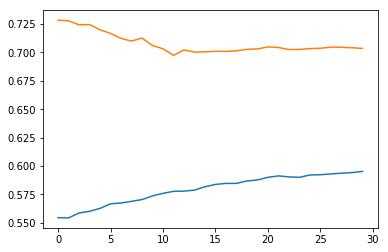

In [36]:
plt.plot(avg_accuracy1)
plt.plot(avg_accuracy2)

In [37]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

Min: 0.5273833671399595
Max: 0.632183908045977
Avg: 0.5952445345954475
Std: 0.024636648193087172


In [38]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

Min: 0.5598377281947262
Max: 0.7592968221771467
Avg: 0.7034708136128015
Std: 0.042619125003043


In [39]:
score_combined = []

for i in range(30):
    score_combined.append(scores[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

Min: 0.5605138607167005
Max: 0.6964164976335362
Avg: 0.6474194275411314
Std: 0.03416476216733158


#### vacsia vstupna mnozina oznacenych dat a vyssi pocet iteracii

In [40]:
scores = [[0 for _ in range(3)] for _ in range(30)]

for x in range(30):
    df_x0 = X_train[y_train == 0].sample(20)
    df_x1 = X_train[y_train == 1].sample(20)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression(n_jobs=-1)
    clf2 = LogisticRegression(n_jobs=-1)

    new_1, new_2, scores[x][0], scores[x][1] = co_training(L=train,U=x_train, 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, k=60, 
                                                           n=2, p=2, X_test=X_test, y_test=y_test)
    
    
    print("iteration: ",x)
#     pred = new_1.predict(X_test[col_names1])
#     scores[0].append(accuracy_score(y_test, pred))

#     pred = new_2.predict(X_test[col_names2])
#     scores[1].append(accuracy_score(y_test, pred))

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores[x][2] = accuracy_score(y_test, pred)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [42]:
avg_accuracy1 = []
avg_accuracy2 = []
model_accuracy1 = []
model_accuracy2 = []
for i in range(60):
    sum_1 = 0 
    sum_2 = 0
    for j in range(30):
        sum_1 += scores[j][0][i]
        sum_2 += scores[j][1][i]
        if i == 29:
            model_accuracy1.append(scores[j][0][i])
            model_accuracy2.append(scores[j][1][i])
    avg_accuracy1.append(sum_1 / 30)
    avg_accuracy2.append(sum_2 / 30)

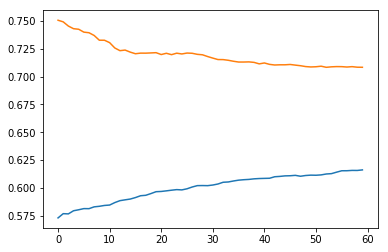

In [43]:
plt.plot(avg_accuracy1)
plt.plot(avg_accuracy2)

In [44]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

Min: 0.47734956051386074
Max: 0.6335361730899256
Avg: 0.6020283975659229
Std: 0.03459332567738214


In [45]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

Min: 0.5645706558485463
Max: 0.77079107505071
Avg: 0.7180302005859815
Std: 0.04087610531848405


In [46]:
score_combined = []

for i in range(30):
    score_combined.append(scores[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

Min: 0.4658553076402975
Max: 0.7085868830290737
Avg: 0.6691683569979718
Std: 0.04343632703663104


### Co-training s prahovou hodnotou (threshold)

In [47]:
def co_training_threshold(L, U, col_names1, col_names2, clf1, clf2, 
                          label='label', random_state=None, X_test=None, y_test=None, threshold=0.8, 
                         n=5, p=5):
    '''
    L - labeled data
    U - unlabeled data
    col_names1 - columns for clf1
    col_names2 - columns for clf2
    clf1 - classificator1
    clf2 - classificator2
    label - name of column in L whit label
    threshold - threshold of predictions probability
    '''
    
    pred_1 = []
    pred_2 = []
#     print("next")
    while len(U) > n + p:
#         print("labeled data:", len(L))
        # step 1: Use L to train a classifier h1 that considers only the x1 portion of x
        clf1 = clf1.fit(L[col_names1],  L[label])
        
        # step 2: Use L, to train a classifier h2 that considers only the x2 portion of x
        clf2 = clf2.fit(L[col_names2], L[label])
        
        # step 3: Allow hl to label p positive and n negative examples from U
        predicted_prob1 = clf1.predict_proba(U[col_names1])
#         print(predicted_prob1[predicted_prob1[:,1].argsort()[-p:],1])
        top_positive1 = [x for x in predicted_prob1[:,1].argsort()[-p:] if predicted_prob1[x,1] > threshold] 
        top_negative1 = [x for x in predicted_prob1[:,0].argsort()[-p:] if predicted_prob1[x,0] > threshold]
        
        
        
        # step 4: Allow hl to label p positive and n negative examples from U
        predicted_prob2 = clf2.predict_proba(U[col_names2]) 
        top_positive2 = [x for x in predicted_prob2[:,1].argsort()[-p:] if predicted_prob2[x,1] > threshold]
        top_negative2 = [x for x in predicted_prob2[:,0].argsort()[-n:] if predicted_prob2[x,0] > threshold]
        
        # step 5: Add these self-labeled examples to L, if less n + p labels are added, break 
        if(np.unique(np.concatenate((top_positive1,top_positive2, top_negative1, top_negative2))).size < n + p):
            if (X_test is not None and y_test is not None):
                pred = clf1.predict(X_test[col_names1])
                pred_1.append(accuracy_score(y_test,pred))

                pred = clf2.predict(X_test[col_names2])
                pred_2.append(accuracy_score(y_test,pred))
                
            return [clf1,clf2, pred_1, pred_2]
        
        
        positive_ind = U.iloc[np.unique(np.concatenate((top_positive1,top_positive2))),:].index
        negative_ind = U.iloc[np.unique(np.concatenate((top_negative1,top_negative2))),:].index
        self_labeled = U.loc[np.unique(np.concatenate((positive_ind,negative_ind))),:]
        U.drop(self_labeled.index, inplace=True)
        self_labeled.loc[positive_ind, label] = 1
        self_labeled.loc[negative_ind, label] = 0
        L = pd.concat([L, self_labeled])
        
        if (X_test is not None and y_test is not None):
            pred = clf1.predict(X_test[col_names1])
            pred_1.append(accuracy_score(y_test,pred))
            
            pred = clf2.predict(X_test[col_names2])
            pred_2.append(accuracy_score(y_test,pred))
    
    return [clf1, clf2, pred_1, pred_2]

In [49]:
scores_threshold = [[0 for _ in range(3)] for _ in range(30)]

for x in range(30):
    df_x0 = X_train[y_train == 0].sample(10)
    df_x1 = X_train[y_train == 1].sample(10)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression(n_jobs=-1)
    clf2 = LogisticRegression(n_jobs=-1)

    new_1, new_2, scores_threshold[x][0], scores_threshold[x][1] = co_training_threshold(L=train.copy(),U=x_train.copy(), 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, 
                                                                     X_test=X_test, y_test=y_test, 
                                                                     n=5,p=5,threshold=0.90)
    print("iteration: ",x)
    
#     pred = new_1.predict(X_test[col_names1])
#     scores[0].append(accuracy_score(y_test, pred))

#     pred = new_2.predict(X_test[col_names2])
#     scores[1].append(accuracy_score(y_test, pred))

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores_threshold[x][2] = accuracy_score(y_test, pred)

iteration:  0
iteration:  1
iteration:  2
iteration:  3
iteration:  4
iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29


In [71]:
# avg_accuracy1 = []
# avg_accuracy2 = []
# model_accuracy1 = []
# model_accuracy2 = []
# for i in range(len(scores_threshold)):
#     sum_1 = 0 
#     sum_2 = 0
#     for j in range(30):
#         sum_1 += scores_threshold[j][0][i]
#         sum_2 += scores_threshold[j][1][i]
#         if i == 29:
#             model_accuracy1.append(scores_threshold[j][0][i])
#             model_accuracy2.append(scores_threshold[j][1][i])
#     avg_accuracy1.append(sum_1 / 30)
#     avg_accuracy2.append(sum_2 / 30)

In [80]:
model_accuracy1 = []
model_accuracy2 = []
for j in range(30):
    model_accuracy1.append(scores_threshold[j][0][-1])
    model_accuracy2.append(scores_threshold[j][1][-1])    

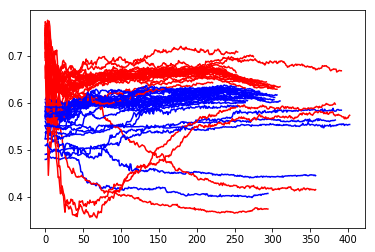

In [66]:
for j in range(30):
    plt.plot(scores_threshold[j][0],'b')
    plt.plot(scores_threshold[j][1], 'r')

In [81]:
print("Min: " + str(np.min(model_accuracy1)))
print("Max: " + str(np.max(model_accuracy1)))
print("Avg: " + str(np.mean(model_accuracy1)))
print("Std: " + str(np.std(model_accuracy1)))

Min: 0.4077079107505071
Max: 0.6348884381338742
Avg: 0.5931034482758621
Std: 0.04961430776674959


In [82]:
print("Min: " + str(np.min(model_accuracy2)))
print("Max: " + str(np.max(model_accuracy2)))
print("Avg: " + str(np.mean(model_accuracy2)))
print("Std: " + str(np.std(model_accuracy2)))

Min: 0.3745774171737661
Max: 0.7085868830290737
Avg: 0.6352715798963263
Std: 0.07040715773718627


In [51]:
score_combined = []

for i in range(30):
    score_combined.append(scores_threshold[i][2])

print("Min: " + str(np.min(score_combined)))
print("Max: " + str(np.max(score_combined)))
print("Avg: " + str(np.mean(score_combined)))
print("Std: " + str(np.std(score_combined)))

Min: 0.3881000676132522
Max: 0.6470588235294118
Avg: 0.6066486364660807
Std: 0.05551309704344202


#### Vacsi pocet vstupnych oznacenych dat

In [ ]:
scores_threshold = [[0 for _ in range(3)] for _ in range(30)]

for x in range(30):
    df_x0 = X_train[y_train == 0].sample(20)
    df_x1 = X_train[y_train == 1].sample(20)
    
    train = pd.concat([df_x0,df_x1])
    x_train = X_train.drop(train.index)
    train['label'] = y_train.loc[train.index]

    clf1 = LogisticRegression(n_jobs=-1)
    clf2 = LogisticRegression(n_jobs=-1)

    new_1, new_2, scores_threshold[x][0], scores_threshold[x][1] = co_training_threshold(L=train.copy(),U=x_train.copy(), 
                               col_names1=col_names1,
                               col_names2=col_names2, clf1=clf1, clf2=clf2, 
                                                                     X_test=X_test, y_test=y_test, 
                                                                     n=5,p=5,threshold=0.90)
    print(x)
    
#     pred = new_1.predict(X_test[col_names1])
#     scores[0].append(accuracy_score(y_test, pred))

#     pred = new_2.predict(X_test[col_names2])
#     scores[1].append(accuracy_score(y_test, pred))

    cl = CombinedClassifier(new_1,new_2,col_names1,col_names2)
    pred = cl.predict(X_test)
    scores_threshold[x][2] = accuracy_score(y_test, pred)

In [ ]:
avg_accuracy1 = []
avg_accuracy2 = []
model_accuracy1 = []
model_accuracy2 = []
for i in range(30):
    sum_1 = 0 
    sum_2 = 0
    for j in range(len(scores_threshold)):
        sum_1 += scores_threshold[j][0][i]
        sum_2 += scores_threshold[j][1][i]
        if i == 29:
            model_accuracy1.append(scores_threshold[j][0][i])
            model_accuracy2.append(scores_threshold[j][1][i])
    avg_accuracy1.append(sum_1 / 30)
    avg_accuracy2.append(sum_2 / 30)

### Self-training

In [68]:
from frameworks.SelfLearning import *

In [69]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

In [70]:
scores_supervised = []
for x in range(30):
    
    df_x0 = X_train[y_train == 0].sample(10)
    df_x1 = X_train[y_train == 1].sample(10)
    
    train = pd.concat([df_x0,df_x1])
    y_train_s = y_train.copy()
    y_train_s[y_train.index.difference(train.index)] = -1
    
    
    benchmark_clf = RandomForestClassifier(n_estimators=500, max_depth=20,
                              random_state=10)
    ssmodel = SelfLearningModel(benchmark_clf)
    ssmodel.fit(X_train.as_matrix(), y_train_s.as_matrix())
    
    y_pred = ssmodel.predict(X_test)
    scores_supervised.append(accuracy_score(y_pred,y_test))

In [72]:
print("Min: " + str(np.min(scores_supervised)))
print("Max: " + str(np.max(scores_supervised)))
print("Avg: " + str(np.mean(scores_supervised)))
print("Std: " + str(np.std(scores_supervised)))

Min: 0.49290060851926976
Max: 0.7085868830290737
Avg: 0.5438810006761325
Std: 0.07359697584173024


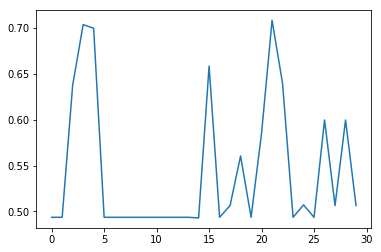

In [73]:
plt.plot(scores_supervised)

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

import classifiers
from classifiers import CoTrainingClassifier

In [75]:
# df_x0 = X_train[y_train == 0].sample(5)
# df_x1 = X_train[y_train == 1].sample(5)

In [76]:
# train = pd.concat([df_x0,df_x1])
# X_train.drop(train.index, inplace=True)
# train['label'] = y_train.loc[train.index]

In [ ]:
tmp1 = set(y_train[y_train == 0].sample(5).index) | set(y_train[y_train == 1].sample(5).index)
tmp2 = set(y_train.index) - set(tmp1)
y_train.loc[tmp2] = -1

In [ ]:
X_train.head()

In [66]:
y_train[y_train != -1].index

Int64Index([7227, 180, 1377, 1836, 2066, 4897, 5355, 938, 1059, 1585], dtype='int64')

In [68]:
lg_co_clf = CoTrainingClassifier(LogisticRegression(), p=2, n=2)
lg_co_clf.fit(X_train[col_names1].reset_index(), X_train[col_names2].reset_index(), y_train.reset_index())
y_pred = lg_co_clf.predict(X_test[col_names1], X_test[col_names2])
print (classification_report(y_test, y_pred))

### Predikovanie pomocou maleho poctu oznacenych dat bez co-trainingu

In [77]:
scores_supervised = []

for x in range(30):
    
    df_x0 = X_train[y_train == 0].sample(10)
    df_x1 = X_train[y_train == 1].sample(10)
    
    train = pd.concat([df_x0,df_x1])
    train['label'] = y_train.loc[train.index]
    
    benchmark_clf = RandomForestClassifier(n_estimators=500, max_depth=20,
                              random_state=10)
    
    benchmark_clf.fit(train[train.columns.difference(['label'])], train['label'])
    y_pred = benchmark_clf.predict(X_test)
    scores_supervised.append(accuracy_score(y_pred,y_test))


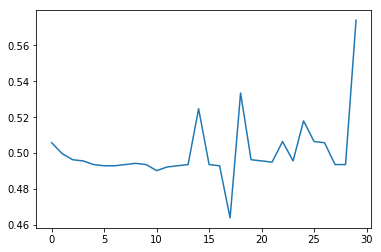

In [78]:
plt.plot(scores_supervised)

In [79]:
print("Min: " + str(np.min(scores_supervised)))
print("Max: " + str(np.max(scores_supervised)))
print("Avg: " + str(np.mean(scores_supervised)))
print("Std: " + str(np.std(scores_supervised)))

Min: 0.4638269100743746
Max: 0.5740365111561866
Avg: 0.500518368266847
Std: 0.01804816549226645
